In [1]:
import torch
import triton
import triton.language as tl

### Naive Torch implementation

In [19]:
def naive_reduction(x:torch.Tensor):
  return torch.sum(x)

In [27]:
@triton.jit
def add_fn(a, b):
  return a + b

In [32]:
@triton.jit
def reduction_kernel(x_ptr, y_ptr, N, BLOCK_SIZE: tl.constexpr):
  pid = tl.program_id(0)
  offset = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)

  mask = offset < N
  x = tl.load(x_ptr + offset, mask = mask, other = 0.0)

  block_sum = tl.reduce(x, axis=0, combine_fn=add_fn)

  tl.atomic_add(y_ptr, block_sum)

In [33]:
def parallel_reduction(x:torch.Tensor):
  N = x.shape[0]

  output = torch.zeros(1, device = "cuda")

  BLOCK_SIZE = 128
  grid = (triton.cdiv(N, BLOCK_SIZE),)

  reduction_kernel[grid](x, output, N, BLOCK_SIZE=BLOCK_SIZE)

  return output.item()

In [38]:
import time

N = 1024 * 1024

x = torch.randn(N, device="cuda")

start = time.time()
cpu_result = naive_reduction(x)
end = time.time()
print(f"Naïve CPU Reduction Time: {end - start:.6f} sec")

start = time.time()
gpu_result = parallel_reduction(x)
end = time.time()
print(f"Parallel GPU Reduction Time: {end - start:.6f} sec")

print(f"Results Match: {torch.isclose(torch.tensor(cpu_result), torch.tensor(gpu_result), atol=1e-4)}")


Naïve CPU Reduction Time: 0.000352 sec
Parallel GPU Reduction Time: 0.000745 sec
Results Match: True


<ipython-input-38-8a26f8110f33>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"Results Match: {torch.isclose(torch.tensor(cpu_result), torch.tensor(gpu_result), atol=1e-4)}")


In [48]:
DEVICE = torch.device("cuda")

In [50]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2**i for i in range(20, 28)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="ms",
        plot_name="reduction-performance",
        args={}
  )
)
def benchmark(size, provider):
    x = torch.randn(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.sum(x), quantiles=quantiles)
    elif provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: parallel_reduction(x), quantiles=quantiles)
    return ms, min_ms, max_ms

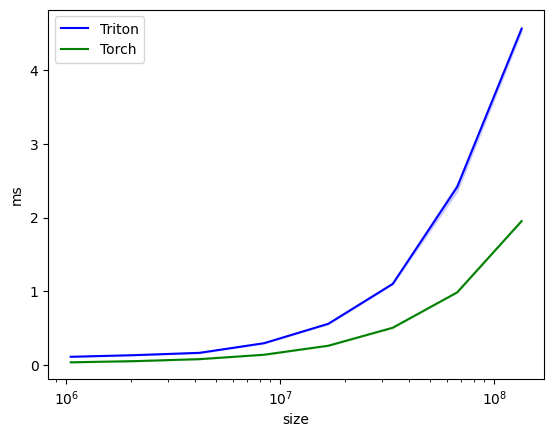

reduction-performance:
          size    Triton     Torch
0    1048576.0  0.111600  0.036848
1    2097152.0  0.134192  0.052960
2    4194304.0  0.165152  0.079744
3    8388608.0  0.295360  0.139360
4   16777216.0  0.558880  0.261728
5   33554432.0  1.100528  0.505760
6   67108864.0  2.413600  0.985088
7  134217728.0  4.560112  1.951680


In [51]:
benchmark.run(print_data=True, show_plots=True)

### Two stage approach to get rid of atomic operations

In [57]:
@triton.jit
def add(a,b):
  return a + b

In [58]:
@triton.jit
def local_reduce_kernel(x_ptr, intermediate_ptr, N, BLOCK_SIZE: tl.constexpr):
  pid = tl.program_id(0)
  offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)

  mask = offsets < N
  x = tl.load(x_ptr + offsets, mask = mask, other = 0.0)

  block_sum = tl.reduce(x, axis=0, combine_fn=add)

  tl.store(intermediate_ptr + pid, block_sum)

In [59]:
@triton.jit
def final_reduce_kernel(intermediate_ptr, y_ptr, num_blocks, BLOCK_SIZE:tl.constexpr):
  pid = tl.program_id(0)
  offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)

  mask = offsets < num_blocks
  intermediate_sum = tl.load(intermediate_ptr + offsets, mask = mask, other = 0.0)

  final_sum = tl.reduce(intermediate_sum, axis=0, combine_fn=add)

  tl.atomic_add(y_ptr, final_sum)

In [60]:
def hierarchical_reduce(x: torch.Tensor, BLOCK_SIZE=1024) -> torch.Tensor:
    assert x.is_cuda, "Input must be on GPU"

    # Stage 1: Partial Reduction Across Blocks
    N = x.numel()
    num_blocks = (N + BLOCK_SIZE - 1) // BLOCK_SIZE
    partial_sums = torch.empty(num_blocks, device=x.device, dtype=x.dtype)

    grid = (num_blocks,)
    local_reduce_kernel[grid](x, partial_sums, N, BLOCK_SIZE=BLOCK_SIZE)


    # Stage 2: Aggregating them and performing final reduction
    out = torch.zeros(1, device=x.device, dtype=x.dtype)

    final_num_blocks = (num_blocks + BLOCK_SIZE - 1) // BLOCK_SIZE
    final_reduce_kernel[(final_num_blocks,)](partial_sums, out, num_blocks, BLOCK_SIZE=BLOCK_SIZE)

    torch.cuda.synchronize()

    return out[0]


In [63]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2**i for i in range(20, 32)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="ms",
        plot_name="reduction-performance",
        args={}
  )
)
def benchmark(size, provider):
    x = torch.randn(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.sum(x), quantiles=quantiles)
    elif provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: hierarchical_reduce(x), quantiles=quantiles)
    return ms, min_ms, max_ms

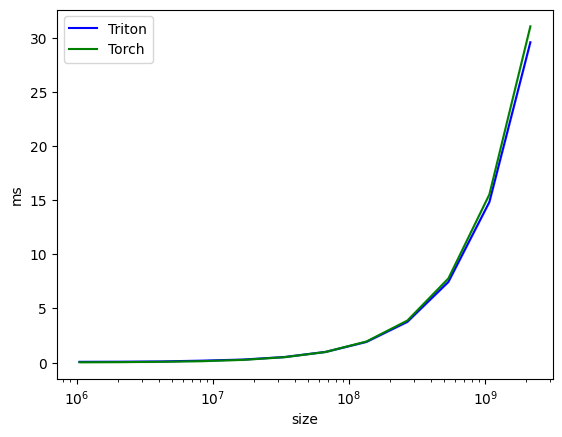

reduction-performance:
            size     Triton      Torch
0   1.048576e+06   0.077344   0.036768
1   2.097152e+06   0.088352   0.050144
2   4.194304e+06   0.114784   0.079712
3   8.388608e+06   0.186048   0.139392
4   1.677722e+07   0.288768   0.260992
5   3.355443e+07   0.521184   0.506736
6   6.710886e+07   0.992464   0.985088
7   1.342177e+08   1.916928   1.951744
8   2.684355e+08   3.769088   3.887088
9   5.368709e+08   7.452672   7.770752
10  1.073742e+09  14.825024  15.522512
11  2.147484e+09  29.570688  31.036575


In [64]:
benchmark.run(print_data=True, show_plots=True)